In [1]:
import os
import tensorflow as tf
import models.unet as unet
from model_util import ImgTester, model_path
from model_util import Saver
from model_util import load_all_imgs

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)


Num GPUs Available 1


In [3]:
kernel_size=(3, 3)
padding="same"
strides=1
image_size = (256,256)
epochs = 30
batch_size= 8
validation_split= 0.2
f = [16, 32, 64, 128, 256]
threshold = 0.5
metric_name = "mean_iou_threshold"
metric = tf.keras.metrics.MeanIoU(num_classes=2, name=metric_name)
base_output_path = '..\\imagens_cra\\result\\unet_mean_iou_threshold_epoch_'+str(epochs)+'_size_'+str(image_size)
x_dir = "../imagens_cra/train/cra"
y_dir = "../imagens_cra/validation/cra"


In [4]:
# Load images
trainImgs = load_all_imgs(x_dir,image_size, 1)
validImgs = load_all_imgs(y_dir,image_size, 0)


../imagens_cra/train/cra found 659 img to load

[0]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[100]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[200]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[300]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[400]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[500]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[600]:||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
../imagens_cra/validation/cra found 659 img to load

[0]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[100]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

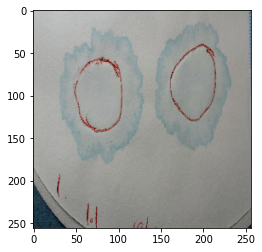

In [5]:
import matplotlib.pyplot as plt
plt.imshow(trainImgs[0])

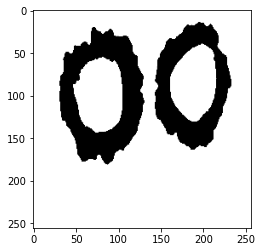

In [6]:
plt.imshow(validImgs[0], cmap=plt.cm.binary)

In [7]:
def mean_iou_threshold(y_true, y_pred):
    y_pred = y_pred.numpy()
    y_pred[y_pred > threshold]= 1
    y_pred[y_pred <= threshold] = 0
    metric.reset_states()
    metric.update_state(y_true, y_pred)
    return metric.result().numpy()

model = unet.build(image_size, f)
model.compile(run_eagerly=True, optimizer="adam", loss="binary_crossentropy", metrics=[mean_iou_threshold])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 16) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [8]:
try:
    os.mkdir(base_output_path)
except OSError as error:
  pass

callbacks = tf.keras.callbacks.ModelCheckpoint(
    model_path(base_output_path),
    monitor=metric_name, verbose=0,
    save_best_only=True,
    mode='auto',
    save_freq='epoch',
)
history = model.fit(
    trainImgs, validImgs,
    epochs=epochs,  batch_size=batch_size, callbacks=callbacks,
    validation_split=validation_split,
)

Epoch 1/30
66/66 [==============================] - 31s 367ms/step - loss: 0.5337 - mean_iou_threshold: 0.4019 - val_loss: 0.3522 - val_mean_iou_threshold: 0.4020

saved to: ..\imagens_cra\result\unet_mean_iou_threshold_epoch_30_size_(256, 256)\acc_por_epocas


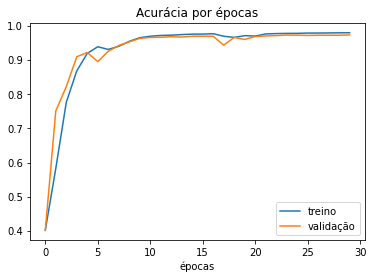

In [12]:
internal_saver = Saver(model, history, base_output_path)
internal_saver.save_metrics(metric_name)

saved to: ..\imagens_cra\result\unet_mean_iou_threshold_epoch_30_size_(256, 256)\loss_por_epocas


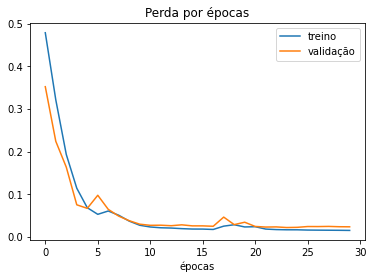

In [10]:
internal_saver.save_loss()

found 659 img to test

[0]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[100]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[200]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[300]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[400]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[500]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[600]:||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Write metrics to: ..\imagens_cra\result\unet_mean_iou_threshold_epoch_30_size_(256, 256)\metrics.csv


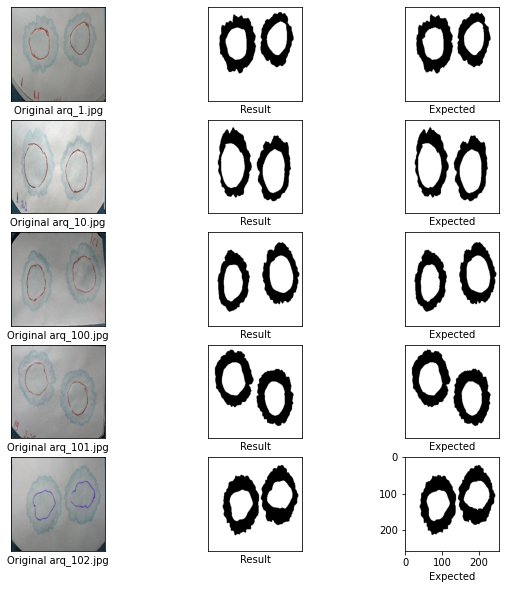

In [13]:
imgTester = ImgTester(base_output_path, x_dir, y_dir, image_size)
imgTester_metrics = [
    metric,
    tf.keras.metrics.MeanIoU(num_classes=2),
    tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=threshold),
]
dependencies = {
    metric_name: mean_iou_threshold,
}
imgTester.test(-1, 5, imgTester_metrics, threshold, dependencies)

